In the "Implementing a B-Tree — Part II" and "Performance Boosts Using a B-Tree" file, we learned how to implement a B-tree. Right now, our implementation allows us to store and lookup key-value pairs. 

In this file, we'll extend it to work as an index for a CSV file where we can perform range queries. A range query gathers all entries with a key in a given range.

Range queries are a common query in SQL. Here's an example:

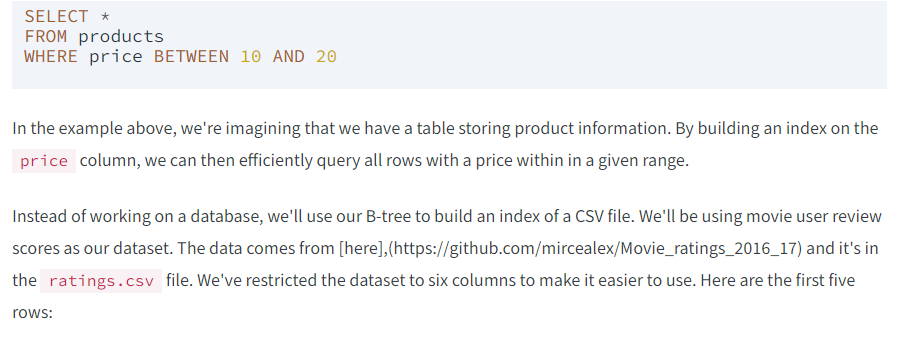

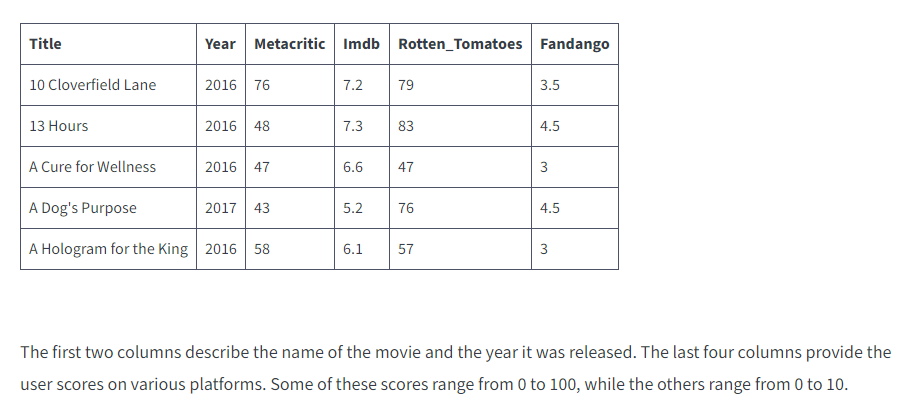

**Task**

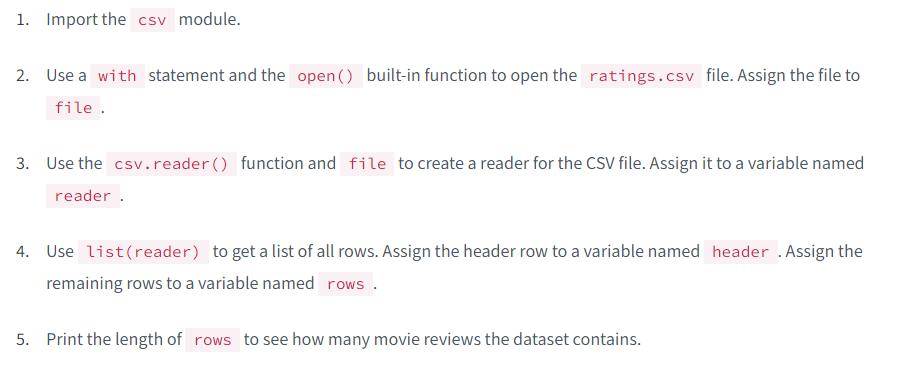

**Answer**

In [1]:
import csv
with open('ratings.csv') as file:
    reader = csv.reader(file)
    rows = list(reader)
    header = rows[0]
    rows = rows[1:]

print(len(rows))

214


We'll implement the index of the B-tree by **extending** the BTree class we wrote in the previous file.

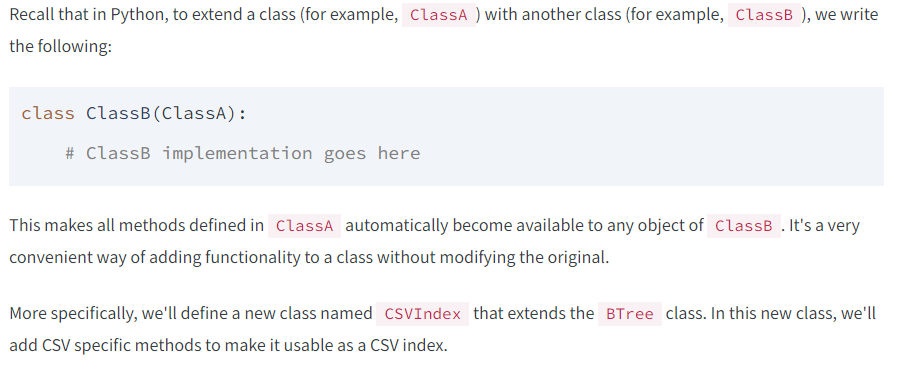

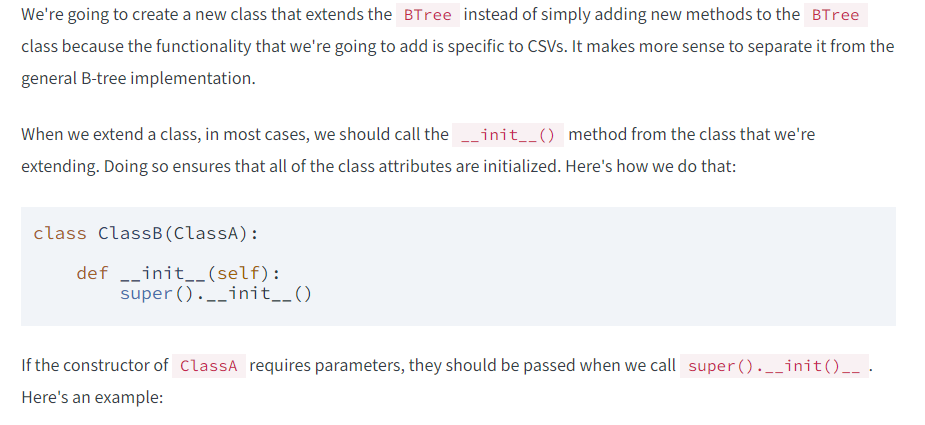

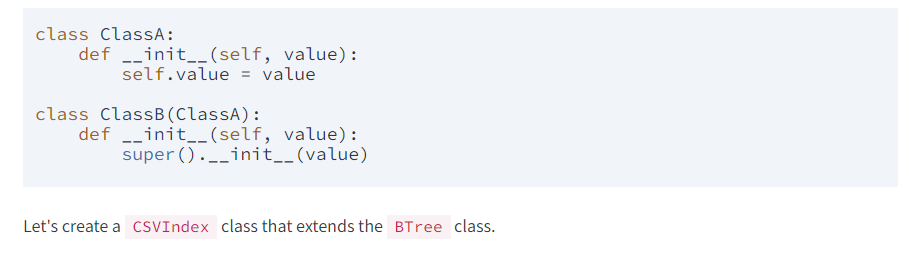

**Task**

The `BTree` class from the "Implementing a B-Tree" file is available in file `btree.py`.

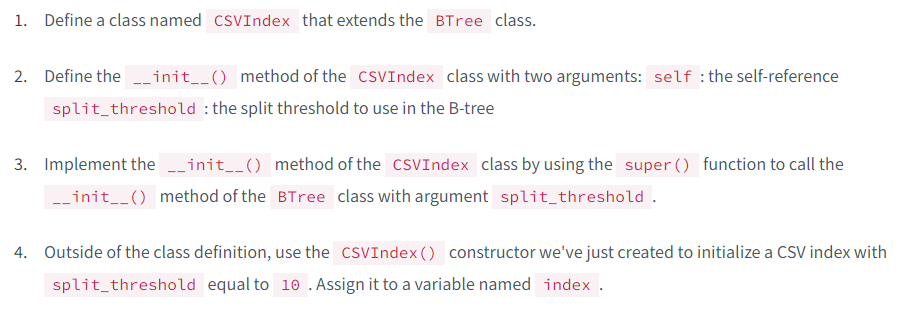


**Answer**

In [2]:
from btree import BTree
class CSVIndex(BTree): # Instruction 1

    def __init__(self, split_threshold): # Instruction 2
        super().__init__(split_threshold) # Instruction 3

# Instruction 4
index = CSVIndex(10)

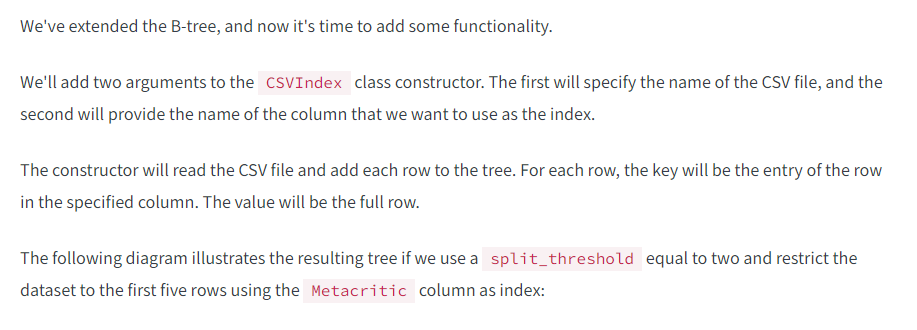

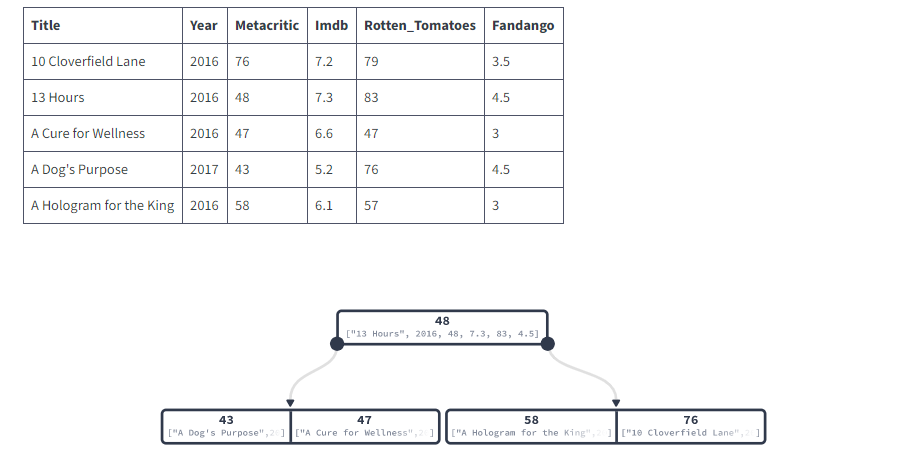

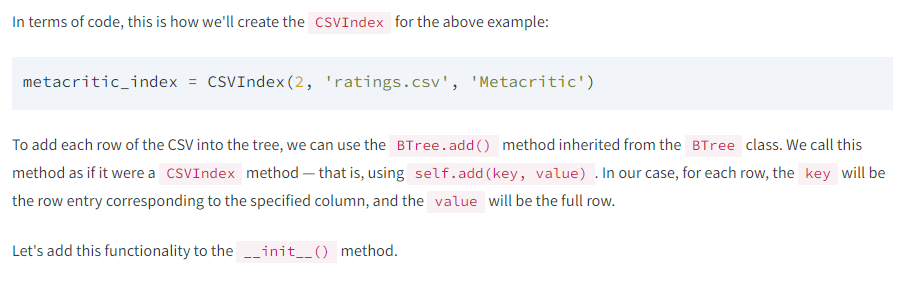

**Task**

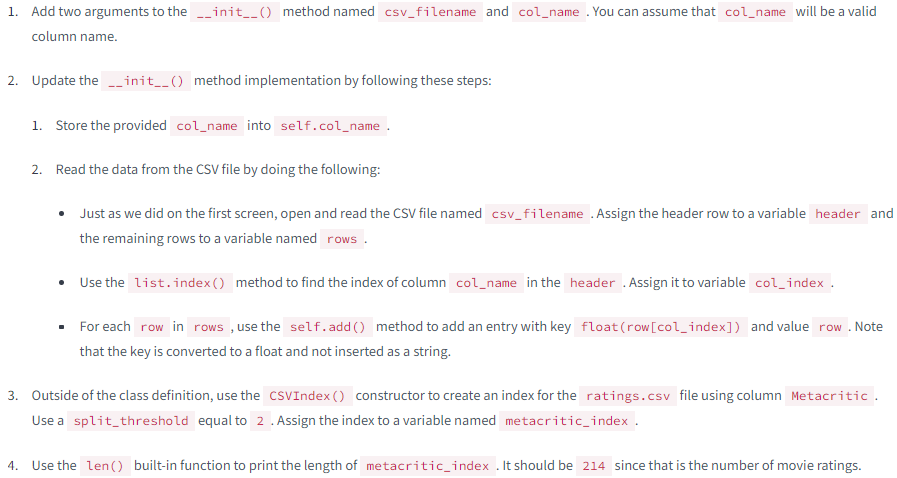

**Answer**

In [3]:
class CSVIndex(BTree):

    def __init__(self, split_threshold, csv_filename, col_name): # Instruction 1
        super().__init__(split_threshold)
        self.col_name = col_name # Instruction 2
        with open(csv_filename) as file: # Instruction 3.1
            rows = list(csv.reader(file))
            header = rows[0]
            rows = rows[2:]
            col_index = header.index(col_name) # Instruction 3.2
            for row in rows: # Instruction 3.3
                self.add(float(row[col_index]), row)
            
metacritic_index = CSVIndex(2, "ratings.csv", "Metacritic") # Instruction 4
print(len(metacritic_index)) # Instruction 5

213


With the current functionality of the `CSVIndex` (inherited from the `BTree`) we can only add new movies and lookup a movie given its index value.

B-trees were designed to work with unique keys, like a dictionary. However, our implementation will still work if we insert multiple entries with the same key. By doing so, we risk degrading the time complexity of some of the operations. We'll discuss this later in the file.

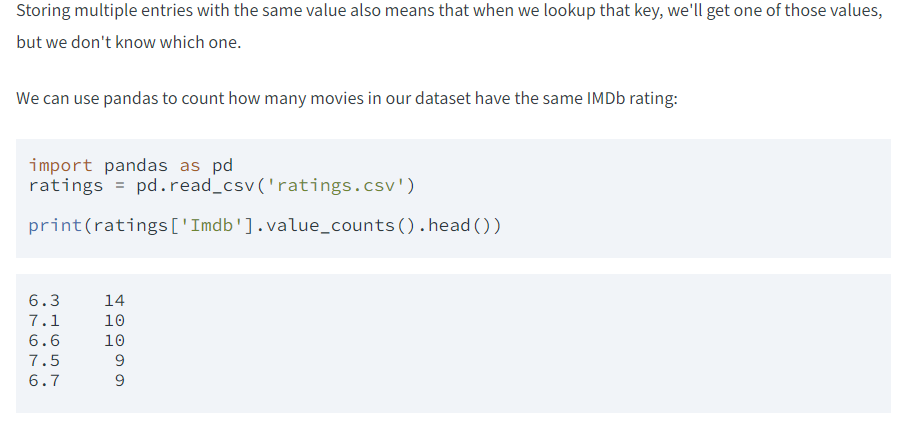

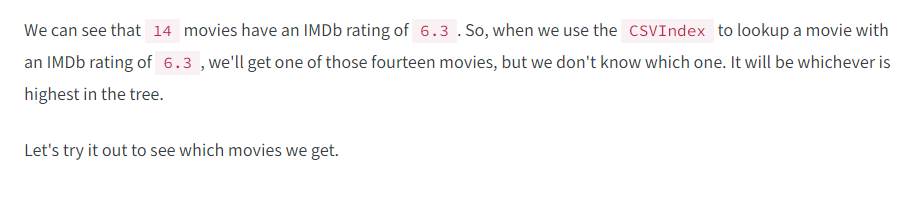

**Task**

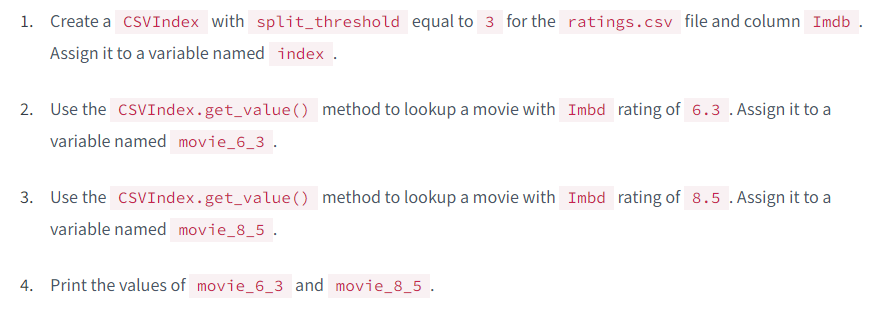

**Answer**

In [4]:
index = CSVIndex(3, "ratings.csv", "Imdb")

movie_6_3 = index.get_value(6.3)
print(movie_6_3)

movie_8_5 = index.get_value(8.5)
print(movie_8_5)

['The 9th Life of Louis Drax', '2016', '41', '6.3', '34', '3.5']
['Logan', '2017', '77', '8.5', '93', '4.5']


Above we looked up a movie with a specific index value. The potential problem is that when several movies have the same rating, we don't get all of them.

Now we'll start implementing a range query method that given two keys `range_start` and `range_end`, returns all entries with keys inside that range. This will also solve the problem of looking up all entries with a given key since if `range_start` and `range_end` are the same, we'll get all entries with key equal to `range_start`.

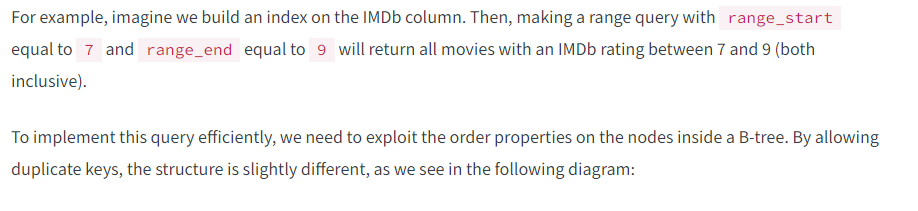

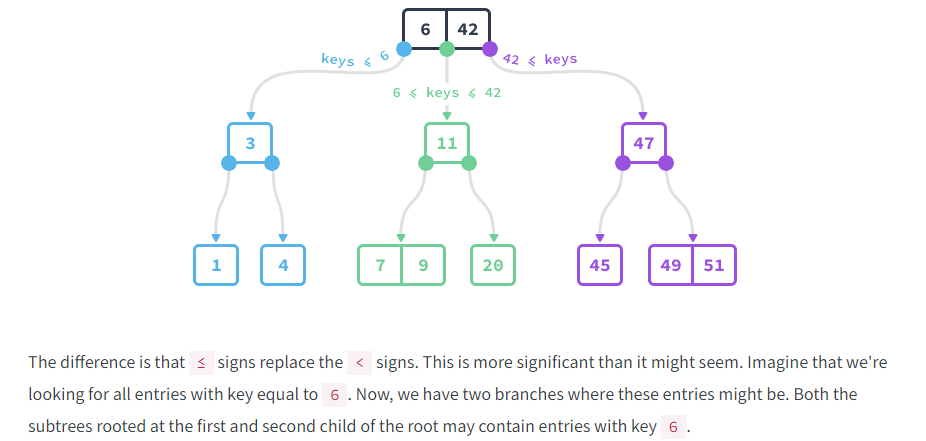

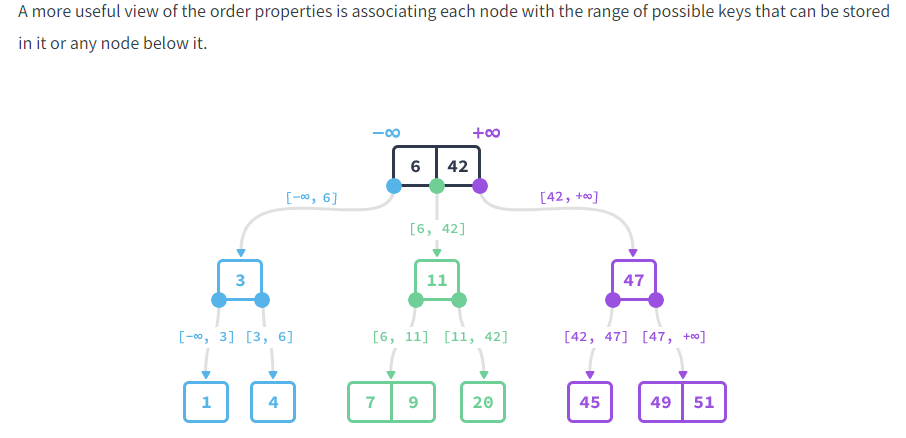

The root node has no restrictions, so we associate the interval [-∞, +∞] with it. This means that the range of keys goes from minus infinity to plus infinity so that the key can be any number. In practice, `float('-inf')` and `float('inf')` represents these values, respectively.

When we go down the tree, the intervals get restricted according to the keys that surround the children.

Let's start implementing the range query method. On this screen, we're going to implement the method signature and the base case of the recursion.

The base case defines when the search will stop. This happens when the current node interval and the query interval no longer intersect.

We'll also add the code necessary to collect all matching entries in the current node.

**Task**

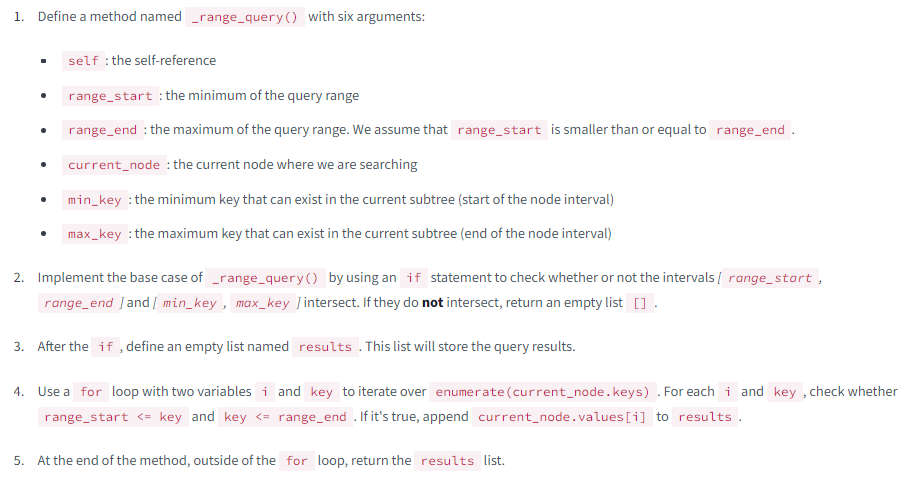

**Answer**

In [5]:
class CSVIndex(BTree):

    def __init__(self, split_threshold, csv_filename, col_name):
        super().__init__(split_threshold)
        self.col_name = col_name
        with open(csv_filename) as file:
            rows = list(csv.reader(file))
            header = rows[0]
            rows = rows[1:]
            col_index = header.index(col_name)
            for row in rows:
                self.add(float(row[col_index]), row)
                
    def _range_query(self, range_start, range_end, current_node, min_key, max_key): # Instruction 1
        if range_start > max_key or range_end < min_key: # Instruction 2
            return []
        results = [] # Instruction 3
        for i, key in enumerate(current_node.keys): # Instruction 4
            if range_start <= key and key <= range_end:
                results.append(current_node.values[i])
        return results # Instruction 5

Above we started to implement a method to perform range queries. So far, we have the following:

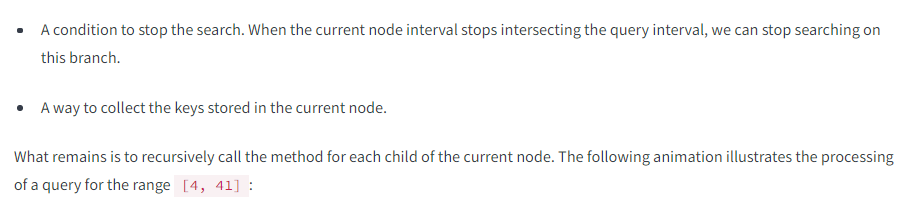

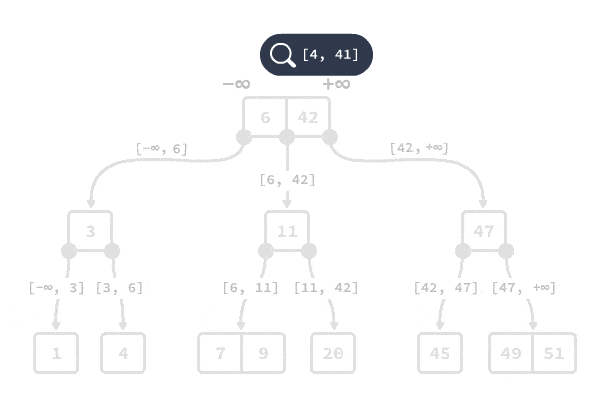

In [7]:
from IPython.display import Image
Image("6.1+-+m519.gif")

Starting at the root, we check which keys are in the query interval and add those entries to the result. Then, for each child, we repeat the same process. The first thing that we check is whether the query range and the node interval intersect. If they don't, we stop the search on this branch of the B-tree. This is what we implemented on the above.

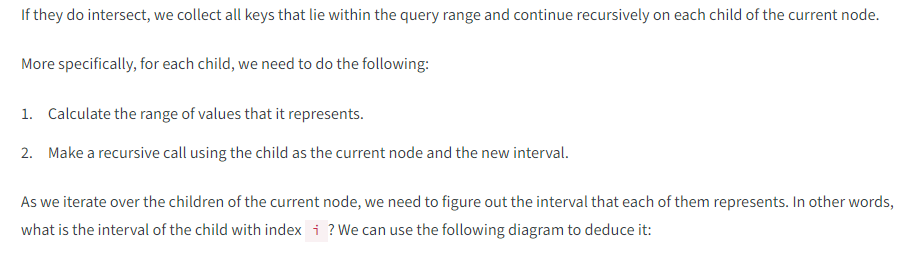

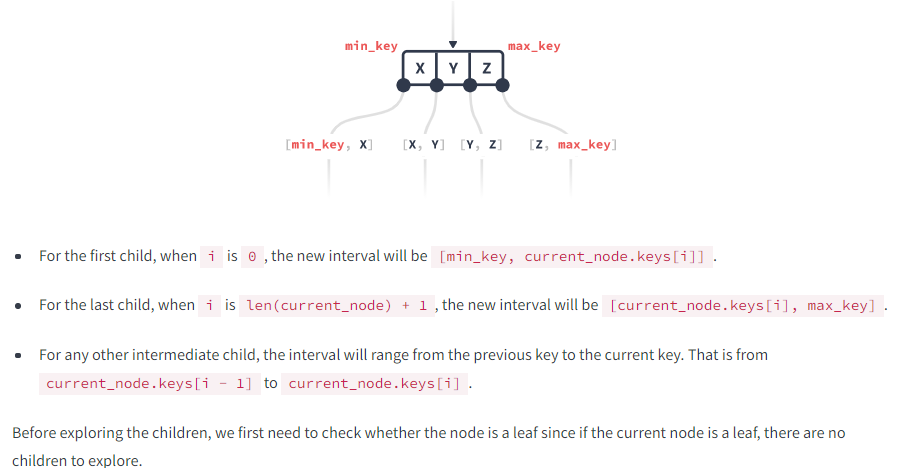

**Task**

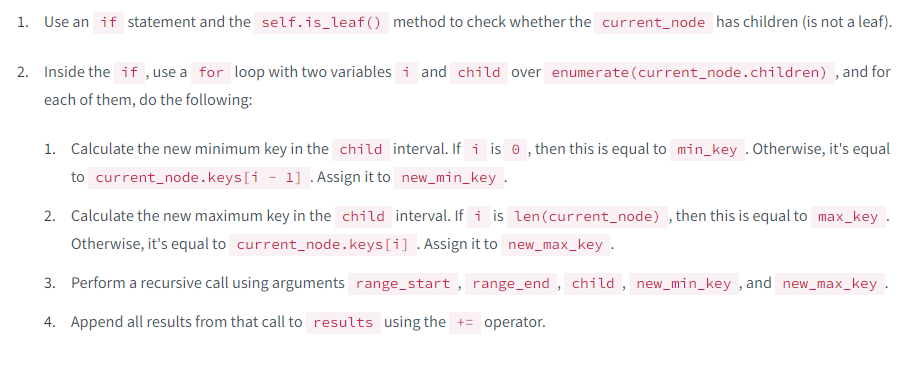

**Answer**

In [8]:
class CSVIndex(BTree):

    def __init__(self, split_threshold, csv_filename, col_name):
        super().__init__(split_threshold)
        self.col_name = col_name
        with open(csv_filename) as file:
            rows = list(csv.reader(file))
            header = rows[0]
            rows = rows[1:]
            col_index = header.index(col_name)
            for row in rows:
                self.add(float(row[col_index]), row)
                
    def _range_query(self, range_start, range_end, current_node, min_key, max_key):
        if range_start > max_key or range_end < min_key:
            return []
        results = []
        for i, key in enumerate(current_node.keys):
            if range_start <= key and key <= range_end:
                results.append(current_node.values[i])
                
        if not current_node.is_leaf(): # Instruction 1
            for i, child in enumerate(current_node.children): # Instruction 2
                new_min_key = min_key if i == 0 else current_node.keys[i - 1] # Instruction 2.1
                new_max_key = max_key if i == len(current_node) else current_node.keys[i] # Instruction 2.2
                results += self._range_query(range_start, range_end, child, new_min_key, new_max_key) # Instructions 2.3, 2.4
        return results

We now have a fully functional range query method. Congratulations!

Now we'll polish our `CSVIndex` by creating a public `range_query()` method that calls the `private _range_query()`.

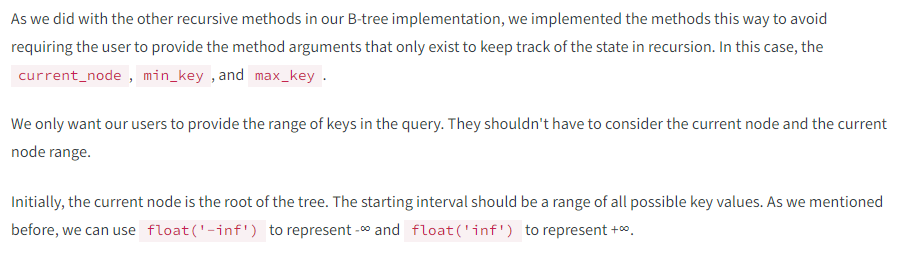

**Task**

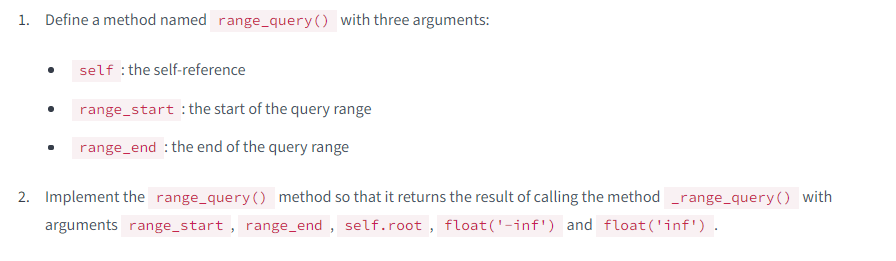

**Answer**

In [9]:
class CSVIndex(BTree):

    def __init__(self, split_threshold, csv_filename, col_name):
        super().__init__(split_threshold)
        self.col_name = col_name
        with open(csv_filename) as file:
            rows = list(csv.reader(file))
            header = rows[0]
            rows = rows[1:]
            col_index = header.index(col_name)
            for row in rows:
                self.add(float(row[col_index]), row)
                
    def _range_query(self, range_start, range_end, current_node, min_key, max_key):
        if range_start > max_key or range_end < min_key:
            return []
        results = []
        for i, key in enumerate(current_node.keys):
            if range_start <= key and key <= range_end:
                results.append(current_node.values[i])
        # Add code here
        if not current_node.is_leaf():
            for i, child in enumerate(current_node.children):
                new_min_key = current_node.keys[i - 1] if i > 0 else min_key
                new_max_key = current_node.keys[i] if i < len(current_node) else max_key
                results += self._range_query(range_start, range_end, child, new_min_key, new_max_key)
        return results 
    
    def range_query(self, range_start, range_end): # Instruction 1
        return self._range_query(range_start, range_end, self.root, float('-inf'), float('inf')) # Instruction 2

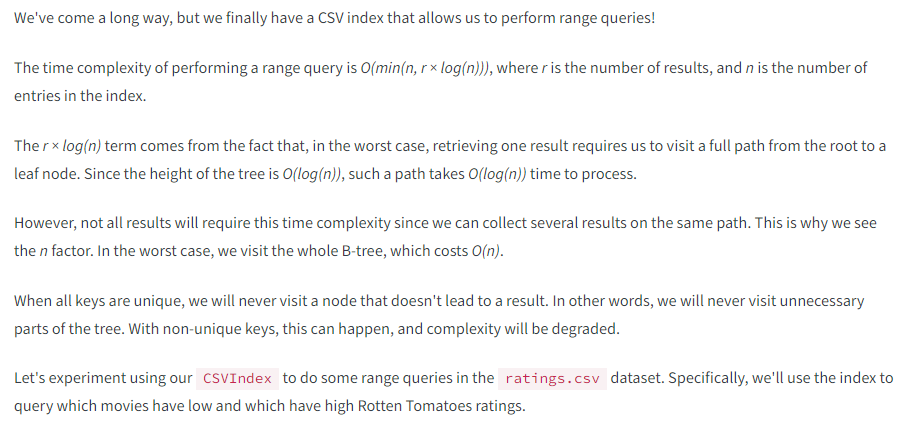

**Task**

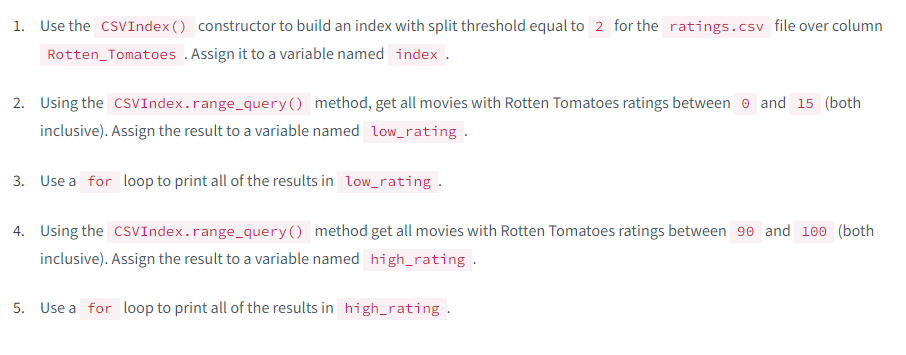

**Answer**

In [10]:
index = CSVIndex(2, 'ratings.csv', 'Rotten_Tomatoes')
low_rating = index.range_query(0, 15)

for movie in low_rating:
    print(movie)

high_rating = index.range_query(90, 100)

for movie in high_rating:
    print(movie)

['Cabin Fever', '2016', '14', '3.7', '11', '4']
['Exposed', '2016', '23', '4.2', '13', '2.5']
['Hacksaw Ridge', '2016', '71', '8.2', '92', '4.5']
['Deadpool', '2016', '65', '8.1', '90', '4.5']
['Moana', '2016', '81', '7.7', '90', '4.5']
['Hunt for the Wilderpeople', '2016', '81', '7.9', '91', '4.5']
['Hidden Figures', '2016', '74', '7.9', '93', '5']
['Lion', '2016', '69', '8.1', '92', '4']
['Zootopia', '2016', '78', '8.1', '92', '4.5']
['Logan', '2017', '77', '8.5', '93', '4.5']
['Sing Street', '2016', '79', '8', '93', '4.5']


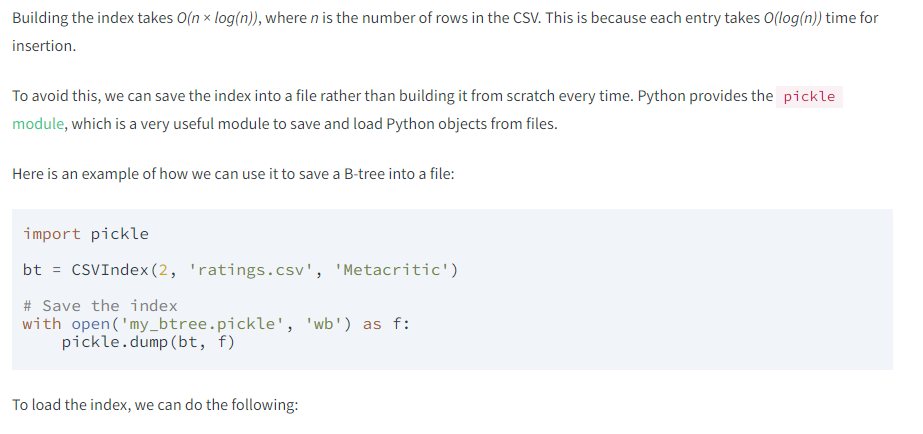

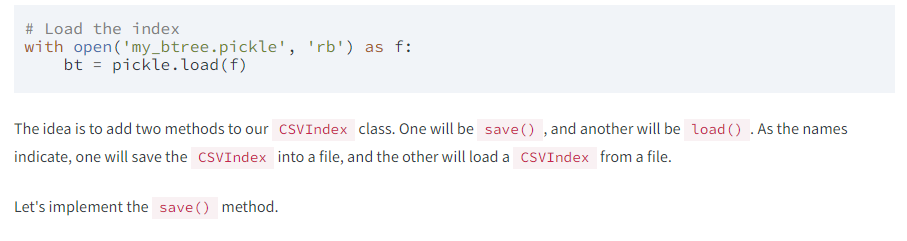

**Task**

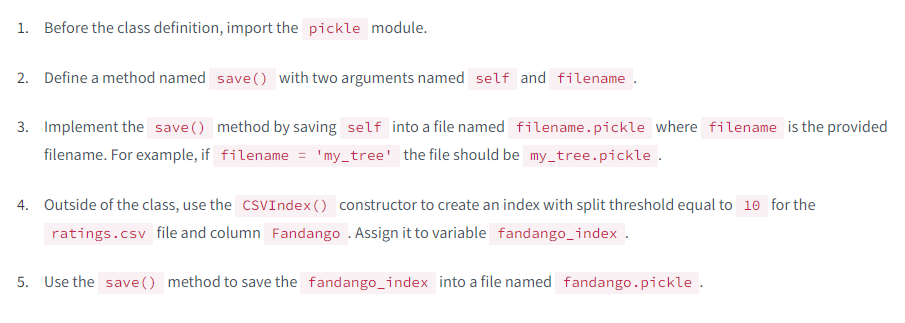

**Answer**

In [11]:
import csv
import pickle # Instruction 1

class CSVIndex(BTree):

    def __init__(self, split_threshold, csv_filename, col_name):
        super().__init__(split_threshold)
        self.col_name = col_name
        with open(csv_filename) as file:
            rows = list(csv.reader(file))
            header = rows[0]
            rows = rows[1:]
            col_index = header.index(col_name)
            for row in rows:
                self.add(float(row[col_index]), row)
                
    def _range_query(self, range_start, range_end, current_node, min_key, max_key):
        if range_start > max_key or range_end < min_key:
            return []
        results = []
        for i, key in enumerate(current_node.keys):
            if range_start <= key and key <= range_end:
                results.append(current_node.values[i])
        # Add code here
        if not current_node.is_leaf():
            for i, child in enumerate(current_node.children):
                new_min_key = current_node.keys[i - 1] if i > 0 else min_key
                new_max_key = current_node.keys[i] if i < len(current_node) else max_key
                results += self._range_query(range_start, range_end, child, new_min_key, new_max_key)
        return results 
    
    def range_query(self, range_start, range_end):
        return self._range_query(range_start, range_end, self.root, float('-inf'), float('inf'))
    
    def save(self, filename): # Instruction 2
        with open('{}.pickle'.format(filename), 'wb') as f: # Instruction 3
            pickle.dump(self, f)

            
fandango_index = CSVIndex(10, 'ratings.csv', 'Fandango') # Instruction 4
fandango_index.save('fandango') # Instruction 5

Now we'll finish our `CSVIndex` implementation with the `load()` method. This method will be **static**. A [static method](https://www.journaldev.com/18722/python-static-method) is a method that can be called without creating an instance of the class.

For example, once we implement the `load()` static method in the `CSVIndex` class, we will be able to load an index as follows:

`loaded_tree = CSVIndex.load('index_filename')`

As we can see, this is different than a normal method. A normal method is called using the syntax `some_instance.method_name()`. In contrast, a static method does not require an instance to be called. The syntax is `ClassName.method_name()`.

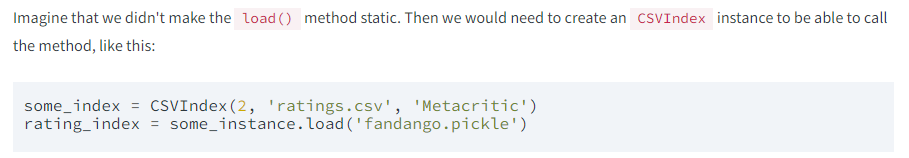

If the above code is troubling us, that's normal. It wouldn't make any sense to have to create some other `CSVIndex` just to load the Fandango index. It also wouldn't make sense to create a `CSVIndex` for the `ratings.csv` file since the purpose of the `load()` method is to avoid recreating the index.

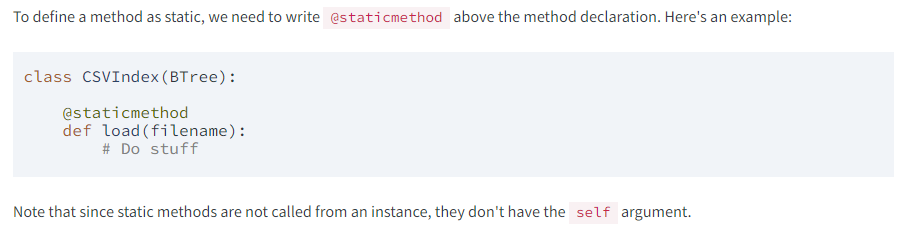

**Task**

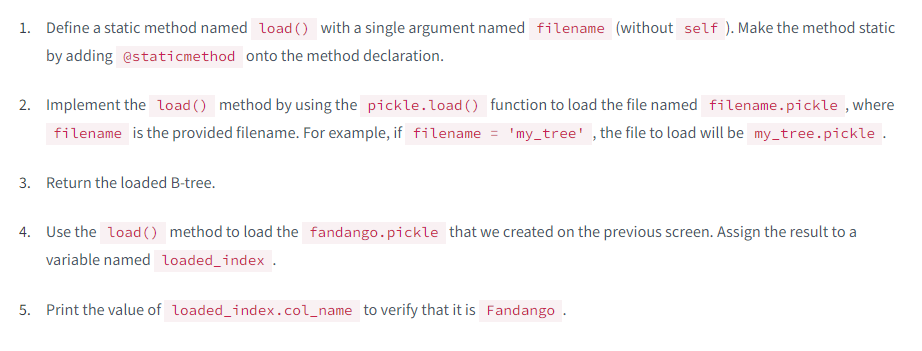

**Answer**

In [12]:
class CSVIndex(BTree):

    def __init__(self, split_threshold, csv_filename, col_name):
        super().__init__(split_threshold)
        self.col_name = col_name
        with open(csv_filename) as file:
            rows = list(csv.reader(file))
            header = rows[0]
            rows = rows[1:]
            col_index = header.index(col_name)
            for row in rows:
                self.add(float(row[col_index]), row)
                
    def _range_query(self, range_start, range_end, current_node, min_key, max_key):
        if range_start > max_key or range_end < min_key:
            return []
        results = []
        for i, key in enumerate(current_node.keys):
            if range_start <= key and key <= range_end:
                results.append(current_node.values[i])
        # Add code here
        if not current_node.is_leaf():
            for i, child in enumerate(current_node.children):
                new_min_key = current_node.keys[i - 1] if i > 0 else min_key
                new_max_key = current_node.keys[i] if i < len(current_node) else max_key
                results += self._range_query(range_start, range_end, child, new_min_key, new_max_key)
        return results 
    
    def range_query(self, range_start, range_end):
        return self._range_query(range_start, range_end, self.root, float('-inf'), float('inf'))
    
    def save(self, filename):
        with open('{}.pickle'.format(filename), 'wb') as f:
            pickle.dump(self, f)
            
    @staticmethod # Instruction 1
    def load(filename): 
        with open('{}.pickle'.format(filename), 'rb') as f: # Instruction 2
            return pickle.load(f) # Instruction 3

loaded_index = CSVIndex.load('fandango') # Instruction 4
print(loaded_index.col_name)

Fandango


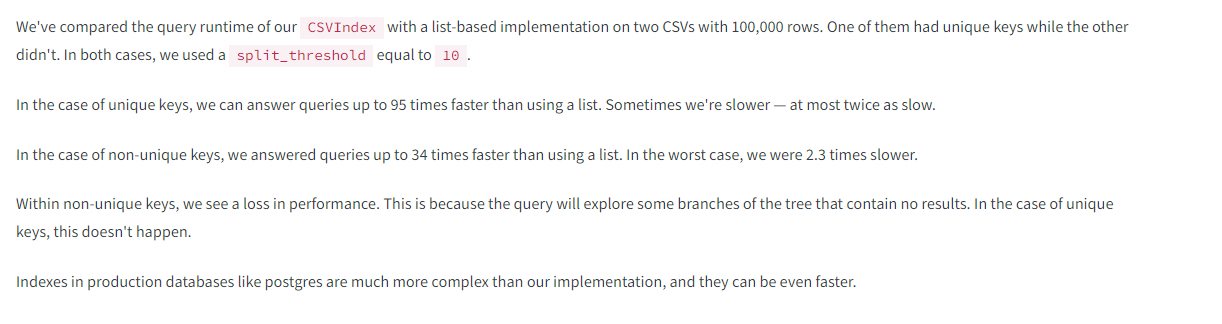

Throughout these file, we didn't pay much attention to the split threshold. But this is why B-trees are especially suited to implement database indexes. By increasing the split threshold, each node becomes bigger, and we have fewer nodes overall. For very large databases, we store indexes on disk. This means that by increasing the split threshold, we lower the number of disk accesses. This is important since disk accesses are much slower.

Next we'll work on a project to refine the implementation of the `CSVIndex`. We'll have the chance to test our knowledge by implementing new functionality to the index. One of the things that we'll work on is extending the index functionality so that we can use non-numeric columns as indexes.